# Laws Textures test

In [1]:
from feature_maps import laws_textures
import cv2, matplotlib.pyplot as plt, os, numpy as np

LABELS_DIR = "dtd/labels"
IMGS_DIR = "dtd/images"

def load_labels():
    out = {}
    with open(os.path.join(LABELS_DIR,"labels_joint_anno.txt"), "r") as f:
        line = f.readline()[:-1]
        while line:
            line         = line.split(" ")
            name, labels = line[0], line[1:]
            out[name]    = labels
            line         = f.readline()[:-1]
    return out

def load_set(labels, set_name = "train", N = 1000000):
    out = {}
    i = 0
    for s in [r for r in os.listdir(LABELS_DIR) if r.startswith("train")]:
        with open(os.path.join(LABELS_DIR,s), "r") as f:
            line = f.readline()[:-1]
            while line:
                img = cv2.imread(os.path.join(IMGS_DIR,line), cv2.IMREAD_GRAYSCALE)
                out[line] = {}
                out[line]["image"] = img
                out[line]["label"] = labels[line]
                line = f.readline()[:-1]
        i += 1
        if i >= N:
            break
    return out

## Load datasets

In [48]:
labes = load_labels()
trainset = load_set(labes, "train", N = 1)
len(trainset), np.unique([trainset[r]["label"][0] for r in trainset])

(1880,
 array(['banded', 'blotchy', 'braided', 'bubbly', 'bumpy', 'chequered',
        'cobwebbed', 'cracked', 'crosshatched', 'crystalline', 'dotted',
        'fibrous', 'flecked', 'freckled', 'frilly', 'gauzy', 'grid',
        'grooved', 'honeycombed', 'interlaced', 'knitted', 'lacelike',
        'lined', 'marbled', 'matted', 'meshed', 'paisley', 'perforated',
        'pitted', 'pleated', 'polka-dotted', 'porous', 'potholed', 'scaly',
        'smeared', 'spiralled', 'sprinkled', 'stained', 'stratified',
        'striped', 'studded', 'swirly', 'veined', 'waffled', 'woven',
        'wrinkled', 'zigzagged'], dtype='<U12'))

## Plot textures

In [3]:
laws = laws_textures(vector_dims = 5)

(346, 391) (195, 173)


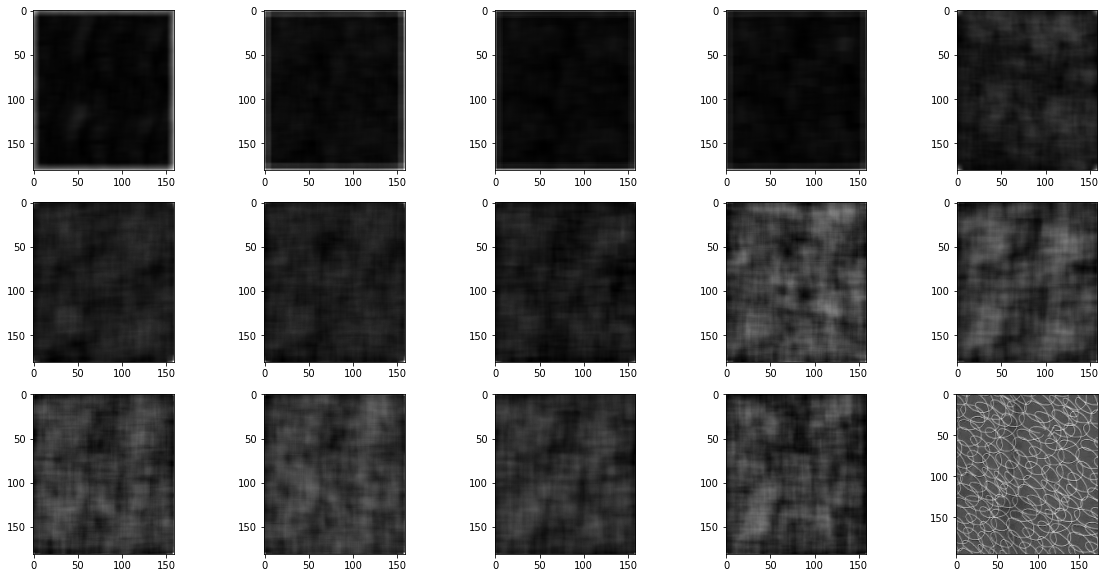

(181, 159, 14)

In [86]:
# np.random.seed(0)
texture = "swirly"
keys = list(trainset.keys())
if texture is not None:
    keys = [r for r in trainset if texture in trainset[r]["label"]]
random_img = np.random.choice(keys)

img = trainset[random_img]["image"]
res = cv2.resize(img, dsize=(img.shape[0]//2, img.shape[1]//2), interpolation = cv2.INTER_CUBIC)
print(img.shape, res.shape)
maps = laws.get_features(res, preprocess = True, merge_symmetric = True, compute_energy = True)

rows = 5
cols = 3
fig, axs = plt.subplots(cols, rows, figsize=(20, 10))

for i in range(cols):
    for j in range(rows):
        index = i*rows+j
        if index == 14:
            axs[i,j].imshow(res, cmap = "gray")
        else:
            axs[i,j].imshow(maps[...,index], cmap = "gray")
plt.show()
maps.shape

## Generate features

In [5]:
%%time
import tqdm

keys = list(trainset.keys())
for i in tqdm.tqdm(range(100)):
    img_name = keys[i]
    trainset[img_name]["laws"] = laws.get_features(trainset[img_name]["image"])

100%|██████████| 100/100 [01:04<00:00,  1.54it/s]

CPU times: user 1min 1s, sys: 3.01 s, total: 1min 4s
Wall time: 1min 4s


In [90]:
%%time
import tqdm

keys = list(trainset.keys())
for i in tqdm.tqdm(range(100)):
    img_name = keys[i]
    trainset[img_name]["laws"] = laws.get_features(trainset[img_name]["image"], compute_fully = True)

100%|██████████| 100/100 [01:00<00:00,  1.66it/s]

CPU times: user 56.3 s, sys: 3.18 s, total: 59.4 s
Wall time: 1min


In [6]:
X = []
Y = []
for img in trainset:
    if "laws" in trainset[img]:
        for a in range(trainset[img]["laws"].shape[0]):
            for b in range(trainset[img]["laws"].shape[1]):
                X.append(trainset[img]["laws"][a,b,:])
                Y.append(trainset[img]["label"][0])

In [35]:
X = np.array(X)
Y = np.array(Y)
print(len(X), len(Y))

i = list(range(len(X)))
np.random.shuffle(i)
# i = i[:500]
X_small, Y_small = X[i], Y[i]
print(len(X_small), len(Y_small))

21107787 21107787
21107787 21107787


In [22]:
from sklearn.decomposition import PCA

transformer = PCA(n_components = 2)
transformer.fit(X_small)

PCA(n_components=2)

In [36]:
X_2d = transformer.transform(X_small)

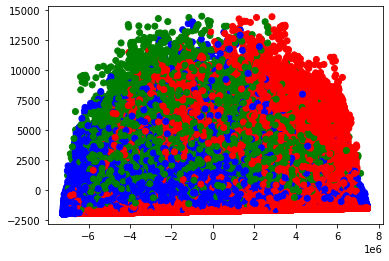

In [38]:
N = 1000000
def get_colors(Y):
    colors = ["red", "green", "blue", "purple", "orange", "pink", "yellow", "black", "lime", "brown"]
    out = []
    mapping = {}
    for y in Y:
        if y not in mapping:
            mapping[y] = colors.pop(0)
        out.append(mapping[y])
    return out
colors = get_colors(Y_small[:N])

plt.scatter(X_2d[:N,0], X_2d[:N,1], c = colors)
plt.show()

## Lines classification

In [91]:
line_classes = ["banded", "lined", "striped"]
for img in trainset:
    if "laws" in trainset[img]:
        for c in trainset[img]["label"]:
            if c in line_classes:
                trainset[img]["class"] = 1
                break
        if "class" not in trainset[img]:
            trainset[img]["class"] = 0

In [92]:
X = []
Y = []
for img in trainset:
    if "laws" in trainset[img]:
        for a in range(trainset[img]["laws"].shape[0]):
            for b in range(trainset[img]["laws"].shape[1]):
                X.append(trainset[img]["laws"][a,b,:])
                Y.append(trainset[img]["class"])

In [109]:
X = np.array(X)
Y = np.array(Y)
print(len(X), len(Y))

i = list(range(len(X)))
np.random.shuffle(i)
i = i[:1000000]
X_small, Y_small = X[i], Y[i]
print(len(X_small), len(Y_small))

21107787 21107787
1000000 1000000


In [110]:
from sklearn.linear_model import LogisticRegression
from bayes_opt import BayesianOptimization

pbounds = {'tol': (.01, .000001), 'C': (1, 3), "penalty": ["l1", "l2", "elasticnet", None]}

def black_box(tol, C, penalty):
    lr = LogisticRegression(tol = tol, C = C, penalty = penalty)
    lr.fit(X_small, Y_small)
    prob = lr.predict_proba(X_small)
    compute_metrics()

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=1,
)

lr = LogisticRegression()
lr.fit(X_small, Y_small)

LogisticRegression()

In [111]:
import sklearn.metrics as metrics

def compute_metrics(y_true, y_prob):
    y_pred      = (y_prob > .5).astype(int)
    accuracy    = metrics.accuracy_score    (y_true = y_true, y_pred = y_pred)
    precision   = metrics.precision_score   (y_true = y_true, y_pred = y_pred)
    recall      = metrics.recall_score      (y_true = y_true, y_pred = y_pred)
    f1_score    = metrics.f1_score          (y_true = y_true, y_pred = y_pred)
    auc         = metrics.roc_auc_score     (y_true = y_true, y_score = y_prob)
    return {"accuracy": accuracy, "precision": precision, 
            "recall": recall, "f1-score": f1_score, "auc": auc}

prob = lr.predict_proba(X_small)
compute_metrics(Y_small, prob[:,1])

{'accuracy': 0.761659,
 'precision': 0.7080261779335222,
 'recall': 0.7725533679421211,
 'f1-score': 0.7388836484705464,
 'auc': 0.8059841589444157}

In [112]:
DIR = "data_participants/processed/train"

def load_train():
    out = []
    for file in os.listdir(DIR):
        if file.endswith(".jpg"):
            path = os.path.join(DIR, file)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            out.append(img)
    return out

trainset = load_train()
len(trainset)

1299

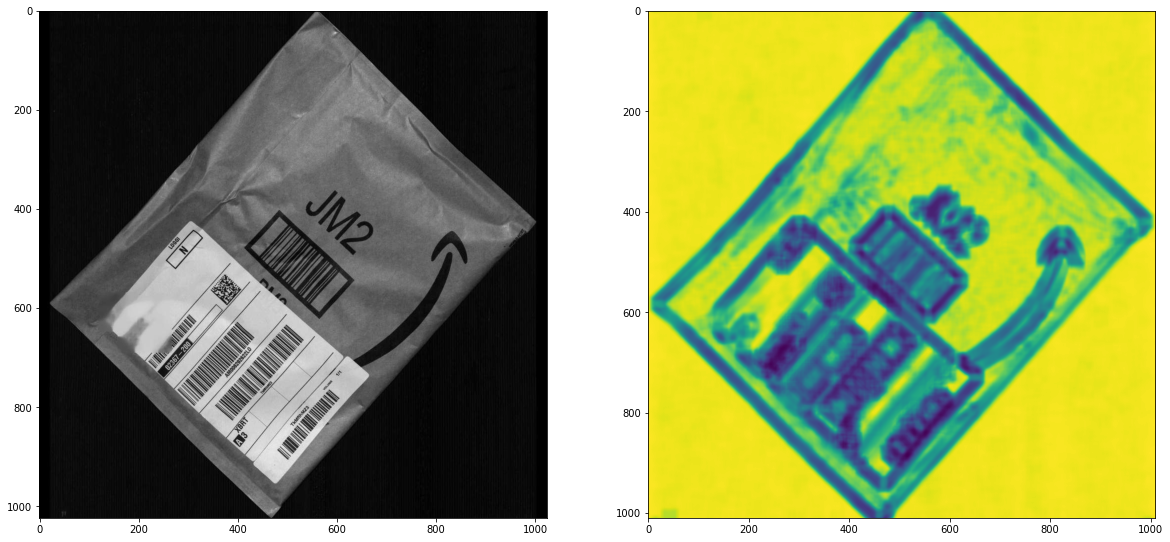

In [153]:
def get_points(maps):
    out = []
    for x in range(maps.shape[0]):
        for y in range(maps.shape[1]):
            out.append( maps[x,y,:] )
    return out

img = trainset[ np.random.choice(len(trainset)) ]
maps = laws.get_features(img, preprocess = True, merge_symmetric = True, compute_energy = True)
points = get_points(maps)

# segmentation = (lr.predict_proba(points)[:,1] > .3).reshape(maps.shape[:2])
segmentation = lr.predict_proba(points)[:,1].reshape(maps.shape[:2])
# segmentation = lr.predict(points).reshape(maps.shape[:2])

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img, cmap = "gray")
axs[1].imshow(segmentation)
plt.show()